In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19/dataset.xlsx


# TASK 1
# • Predict confirmed COVID-19 cases among suspected cases.
## Based on the results of laboratory tests commonly collected for a suspected COVID-19 case during a visit to the emergency room, would it be possible to predict the test result for SARS-Cov-2 (positive/negative)?


# Objetivo principal: - fazer o mínimo de alerações possíveis no dataset em um modelo de boa performance, simples e facilmente replicável 
 


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
%matplotlib inline

In [3]:
df = pd.read_excel('/kaggle/input/covid19/dataset.xlsx', index_col=0)


In [4]:
warnings='ignore'

In [5]:
df.reset_index(drop=False, inplace=True)

In [6]:
df.tail()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
5639,ae66feb9e4dc3a0,3,positive,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,517c2834024f3ea,17,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,5c57d6037fe266d,4,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,c20c44766f28291,10,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5643,2697fdccbfeb7f7,19,positive,0,0,0,0.694287,0.541564,-0.906829,-0.325903,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset capturado, iniciando EDA

In [7]:
df.isnull().sum()

Patient ID                                                  0
Patient age quantile                                        0
SARS-Cov-2 exam result                                      0
Patient addmited to regular ward (1=yes, 0=no)              0
Patient addmited to semi-intensive unit (1=yes, 0=no)       0
                                                         ... 
HCO3 (arterial blood gas analysis)                       5617
pO2 (arterial blood gas analysis)                        5617
Arteiral Fio2                                            5624
Phosphor                                                 5624
ctO2 (arterial blood gas analysis)                       5617
Length: 111, dtype: int64

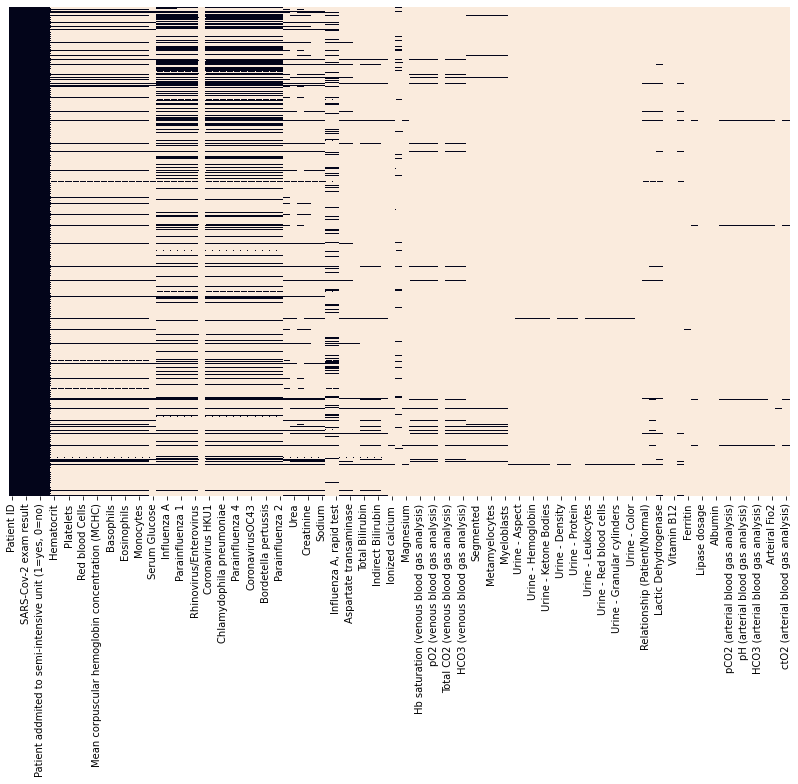

In [8]:
# o número de células com valores NaN é muito grande. Exposição gráfica para melhor visualização
plt.figure(figsize=(14,9))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)

In [9]:
df.notnull().sum()

Patient ID                                               5644
Patient age quantile                                     5644
SARS-Cov-2 exam result                                   5644
Patient addmited to regular ward (1=yes, 0=no)           5644
Patient addmited to semi-intensive unit (1=yes, 0=no)    5644
                                                         ... 
HCO3 (arterial blood gas analysis)                         27
pO2 (arterial blood gas analysis)                          27
Arteiral Fio2                                              20
Phosphor                                                   20
ctO2 (arterial blood gas analysis)                         27
Length: 111, dtype: int64

In [10]:
cols=df.columns

## A separação foi feita até a coluna 40 por relevância em volume de dados

# (colunas com mais de 95% de valores nulos foram eliminadas)

### A idéia é usar somente os exames de sangue mais comum para fazer a análise

In [11]:
relevant = df[cols[0:20]]

In [12]:
relevant['Neutrophils'] = df['Neutrophils']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
relevant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 21 columns):
Patient ID                                               5644 non-null object
Patient age quantile                                     5644 non-null int64
SARS-Cov-2 exam result                                   5644 non-null object
Patient addmited to regular ward (1=yes, 0=no)           5644 non-null int64
Patient addmited to semi-intensive unit (1=yes, 0=no)    5644 non-null int64
Patient addmited to intensive care unit (1=yes, 0=no)    5644 non-null int64
Hematocrit                                               603 non-null float64
Hemoglobin                                               603 non-null float64
Platelets                                                602 non-null float64
Mean platelet volume                                     599 non-null float64
Red blood Cells                                          602 non-null float64
Lymphocytes                            

In [14]:
col = relevant.columns

In [15]:
def falta_numero(x):
      return sum(x.isnull())

In [16]:
relevant.apply(falta_numero, axis=0)

Patient ID                                                  0
Patient age quantile                                        0
SARS-Cov-2 exam result                                      0
Patient addmited to regular ward (1=yes, 0=no)              0
Patient addmited to semi-intensive unit (1=yes, 0=no)       0
Patient addmited to intensive care unit (1=yes, 0=no)       0
Hematocrit                                               5041
Hemoglobin                                               5041
Platelets                                                5042
Mean platelet volume                                     5045
Red blood Cells                                          5042
Lymphocytes                                              5042
Mean corpuscular hemoglobin concentration (MCHC)         5042
Leukocytes                                               5042
Basophils                                                5042
Mean corpuscular hemoglobin (MCH)                        5042
Eosinoph

## A base da análise foi montada usando somente os exames de sangue.
### Existem muitos valores nulos e negativos. Será arescido o número 5 (cinco) nos valores não-nulos (para eliminar os valores negativos);  e o numero 9 (nove) nos valores nulos.

In [17]:
relevant.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,...,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.619086
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
def normaliza (x):
    y = x + 5
    return y

In [19]:
relevant[col[6:21]] = relevant[col[6:21]].apply(normaliza)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [20]:
relevant[col[6:21]] = relevant[col[6:21]].fillna(9)

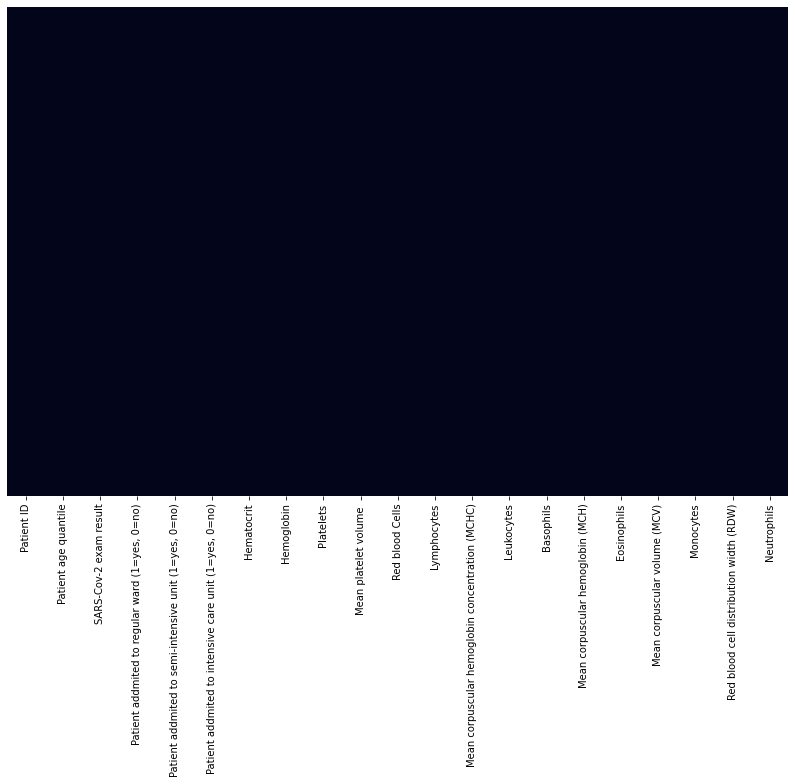

In [21]:
plt.figure(figsize=(14,9))
sns.heatmap(relevant.isnull(), cbar=False, yticklabels=False)

In [22]:
## Eliminamos todos os valores nulos ou negativos
relevant.notnull().sum()

Patient ID                                               5644
Patient age quantile                                     5644
SARS-Cov-2 exam result                                   5644
Patient addmited to regular ward (1=yes, 0=no)           5644
Patient addmited to semi-intensive unit (1=yes, 0=no)    5644
Patient addmited to intensive care unit (1=yes, 0=no)    5644
Hematocrit                                               5644
Hemoglobin                                               5644
Platelets                                                5644
Mean platelet volume                                     5644
Red blood Cells                                          5644
Lymphocytes                                              5644
Mean corpuscular hemoglobin concentration (MCHC)         5644
Leukocytes                                               5644
Basophils                                                5644
Mean corpuscular hemoglobin (MCH)                        5644
Eosinoph

### Finalizar tratamento para aplicar regressão logística

In [23]:
covid = relevant

In [24]:
covid.reset_index(drop=True, inplace=True)

In [25]:
covid.tail()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils
5639,ae66feb9e4dc3a0,3,positive,0,0,0,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000
5640,517c2834024f3ea,17,negative,0,0,0,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000
5641,5c57d6037fe266d,4,negative,0,0,0,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000
5642,c20c44766f28291,10,negative,0,0,0,9.000000,9.000000,9.000000,9.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000
5643,2697fdccbfeb7f7,19,positive,0,0,0,5.694287,5.541564,4.093171,4.674097,...,4.704274,4.646681,3.711572,3.859856,4.864545,4.164492,5.025985,5.567652,4.81721,5.380685


## Eliminando colunas do dataset final que não serão utilizadas na regressão logística

In [26]:
covid = covid.drop(['Patient ID'], axis=1, inplace=True)
covid = relevant

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
covid = covid.drop(['Patient addmited to regular ward (1=yes, 0=no)'], axis=1, inplace=True)
covid = relevant

In [28]:
covid = covid.drop(['Patient addmited to semi-intensive unit (1=yes, 0=no)'], axis=1, inplace=True)
covid = relevant

In [29]:
covid = covid.drop(['Patient addmited to intensive care unit (1=yes, 0=no)'], axis=1, inplace=True)
covid = relevant

In [30]:
covid.head()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils
0,13,negative,9.000000,9.00000,9.000000,9.000000,9.000000,9.000000,9.00000,9.00000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
1,17,negative,5.236515,4.97766,4.482587,5.010677,5.102004,5.318366,4.04921,4.90539,4.776233,4.707731,6.482158,5.166192,5.357547,4.374927,4.380914
2,8,negative,9.000000,9.00000,9.000000,9.000000,9.000000,9.000000,9.00000,9.00000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
3,5,negative,9.000000,9.00000,9.000000,9.000000,9.000000,9.000000,9.00000,9.00000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
4,15,negative,9.000000,9.00000,9.000000,9.000000,9.000000,9.000000,9.00000,9.00000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


In [31]:
# Verificando os valores da coluna target
covid['SARS-Cov-2 exam result'].value_counts()

negative    5086
positive     558
Name: SARS-Cov-2 exam result, dtype: int64

In [32]:
# convertendo celulas categóricas em numericas
covid['SARS-Cov-2 exam result'] = pd.get_dummies(covid['SARS-Cov-2 exam result'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
covid['SARS-Cov-2 exam result'].value_counts()

1    5086
0     558
Name: SARS-Cov-2 exam result, dtype: int64

In [34]:
# verificação final
covid.tail()

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Neutrophils
5639,3,0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000
5640,17,1,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000
5641,4,1,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000
5642,10,1,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000
5643,19,0,5.694287,5.541564,4.093171,4.674097,5.578024,4.704274,4.646681,3.711572,3.859856,4.864545,4.164492,5.025985,5.567652,4.81721,5.380685


# Divisão treino/teste e Regressão Logística com SKlearn

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [36]:
X_train, X_test, y_train, y_test = train_test_split(covid.drop('SARS-Cov-2 exam result',axis=1), covid['SARS-Cov-2 exam result'], test_size=0.25)

In [37]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
predictions = logmodel.predict(X_test)

## Verificação da matriz de confusão (Verdadeiro e falso, positivos e negativos)

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
reg_cm=confusion_matrix(y_test,predictions)
print(reg_cm)

[[   3  122]
 [   2 1284]]


### Função criada para plotar a matriz de confusão

In [41]:
def matriz_deconfusao(cm, target_names,
                          title='Matriz de Confusão',
                          cmap=None,
                          normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


#### Impressão da matriz de confusão e acurácia do modelo

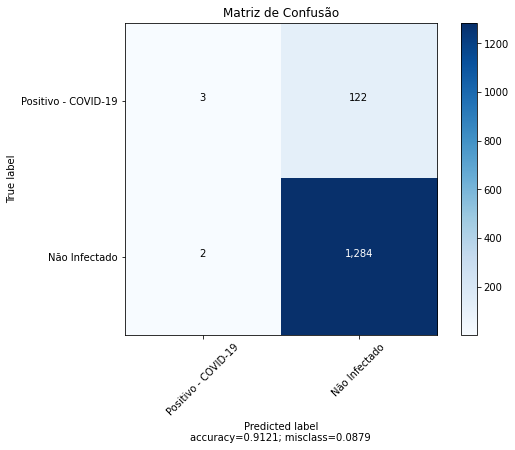

In [42]:
matriz_deconfusao(cm = reg_cm, normalize  = False,
                      target_names = ['Positivo - COVID-19', 'Não Infectado'],
                      title        = "Matriz de Confusão")

# RESPOSTA TASK 1 - SIM, É POSSÍVEL IDENTIFICAR A PRESENÇA DO COVID-19 ATRAVÉS DA ANÁLISE DOS DADOS DOS EXAMES DE SANGUE COM ACURÁCIA DE APROXIMADAMENTE 90% 

# A TASK 2 NÃO FOI POSSÍVEL DE SER CONCLUÍDA, POIS A ANÁLISE DA EVOLUÇÃO DO QUADRO CLÍNICO ENTRE A EMERGÊNCIA ATÉ A UTI REQUER IMAGENS, AVALIAÇÕES E DADOS. 
## SOMENTE COM OS DADOS É IMPOSSÍVEL